In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../code')

# Read Data

In [3]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,Time,ELoss,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,383.880371,5.310523e-06,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,415.954742,5.271870e-07,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,384.254303,3.097434e-06,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,384.251007,3.362202e-06,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,390.597870,1.754228e-06,0


# Toy with Baseline model

In [5]:
from baseline import Baseline
from reconstruction import TracksReconstruction2D
from combination import Combinator

from metrics import TracksReconstractionMetrics, CombinatorQuality

In [6]:
event = data[data.EventID == 270]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

In [7]:
%%time
rt = Baseline(n_max_hits=16, n_min_hits=7, window_width=0.7)

rt.fit(x, y)

labels = rt.labels_
tracks_params = rt.tracks_params_

CPU times: user 6.55 ms, sys: 2.35 ms, total: 8.9 ms
Wall time: 7.07 ms


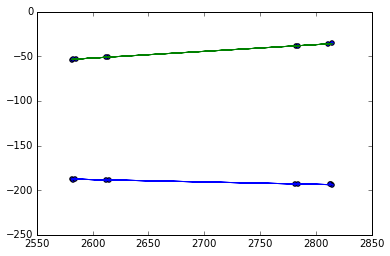

In [8]:
plt.scatter(x, y)
for n in range(len(tracks_params)):
    plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
plt.show()

In [9]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [10]:
tracks_params

array([[ -2.64683163e-02,  -1.19339882e+02],
       [  7.51038001e-02,  -2.47301453e+02]])

In [11]:
labels

array([ 1., -1.,  0.,  1., -1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  1.,  0.,  1., -1.,  1.])

In [12]:
event12.Label.values

array([ 0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.])

# Toy with Artificial Retina model

In [13]:
from retina import Retina2DTrackerTwo

In [14]:
%%time
rt = Retina2DTrackerTwo(n_tracks=2, residuals_threshold=0.2, sigma=0.1, min_hits=2)

rt.fit(x, y)

labels = rt.labels_
tracks_params = rt.tracks_params_

CPU times: user 8.07 ms, sys: 1.86 ms, total: 9.93 ms
Wall time: 8.48 ms


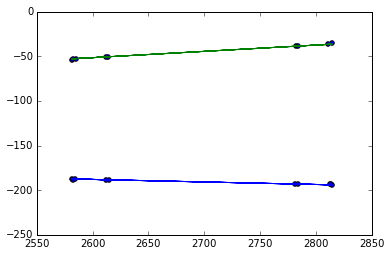

In [15]:
plt.scatter(x, y)
for n in range(len(tracks_params)):
    plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
plt.show()

In [16]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [17]:
tracks_params

array([[ -2.82344182e-02,  -1.14574940e+02],
       [  7.04347513e-02,  -2.34700085e+02]])

In [18]:
labels

array([ 1., -1.,  0.,  1., -1., -1., -1.,  0., -1.,  0., -1., -1., -1.,
       -1., -1.,  0., -1.,  1., -1.])

In [19]:
event12.Label.values

array([ 0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.])

# Tracks Reconstruction

Play with two models: Baseline and Artificial Retina. Variate the models' parameters and look at the quality metrics.

For the Artificial Retina find parameters that provide the best total reconstruction efficiency.

In [21]:
from baseline import Baseline
from retina import Retina2DTrackerTwo
from reconstruction import TracksReconstruction2D
from combination import Combinator

from metrics import TracksReconstractionMetrics, CombinatorQuality

In [25]:
%%time
event_ids = numpy.unique(data.EventID.values)

tracks = {}
tracks_comb = {}

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_true2 = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['EventID', 'RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in event_ids:
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None#1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None#1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    
    
    
    ######### Select model for the tracks reconstruction #############################################
    ##################################################################################################
    
    
    model_y = Baseline(n_max_hits=16, n_min_hits=7, window_width=0.7)
    model_stereo = Baseline(n_max_hits=16, n_min_hits=6, window_width=15)
    
    # model_y = Retina2DTrackerTwo(n_tracks=2, residuals_threshold=0.4, sigma=0.4, min_hits=2)
    # model_stereo = Retina2DTrackerTwo(n_tracks=1, residuals_threshold=7, sigma=7, min_hits=2)
    
    
    ##################################################################################################
    ##################################################################################################
    
    
    
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=model_y, model_stereo=model_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=model_y, model_stereo=model_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    # Save tracks
    tracks[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2, n_tracks=2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
    
    
    
    # Combination of the tracks before and after the magnet
    comb = Combinator()
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
        
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    line = numpy.array([1, 
                         (trm12.recognition_efficiency_y_ == 1)*1, 
                         (trm12.recognition_efficiency_stereo_ >= 1.)*1, 
                         (trm12.recognition_efficiency_ == 1)*1,
                         (trm34.recognition_efficiency_y_ == 1)*1, 
                         (trm34.recognition_efficiency_stereo_ >= 1.)*1, 
                         (trm34.recognition_efficiency_ == 1)*1, 
                         (cq.n_combined_ >= 2)*1,
                         (cq.reco_eff_ == 1)*1]).cumprod()

    pass_stages.loc[len(pass_stages)] = numpy.concatenate(([event_id], line), axis=0)
    
    # Save the tracks combination
    tracks_comb[event_id] = {'tracks_combinations':comb.tracks_combinations_, 
                             'charges':comb.charges_, 
                             'inv_momentums':comb.inv_momentums_}

CPU times: user 30.8 s, sys: 281 ms, total: 31.1 s
Wall time: 31.4 s


# Quality

# Stations 1&2

### Y-views

In [26]:
tracks_metrics_before_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.985774
RecoEff         0.988060
GhostRate       0.001493
CloneRate       0.005224
dtype: float64

### Stereo-views

In [27]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.981017
RecoEff         0.985075
GhostRate       0.001493
CloneRate       0.002239
dtype: float64

### Stations 1&2

In [28]:
tracks_metrics_before_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.982834
RecoEff         0.990299
GhostRate       0.001493
CloneRate       0.002985
dtype: float64

### Track efficiency

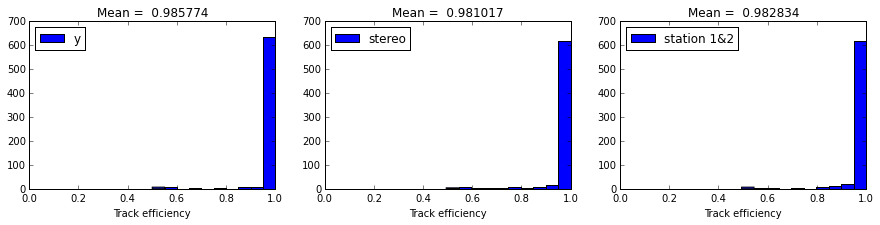

In [29]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

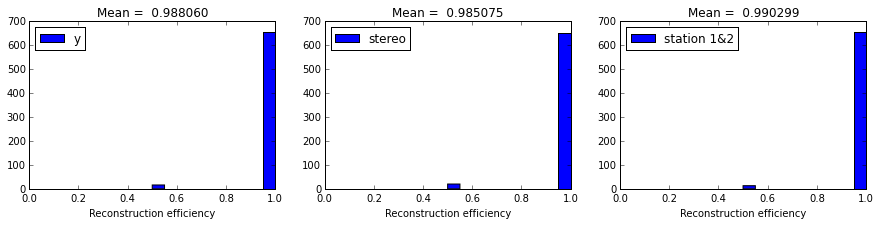

In [30]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [31]:
tracks_metrics_after_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.992310
RecoEff         0.986567
GhostRate       0.008209
CloneRate       0.001493
dtype: float64

### Stereo-views

In [32]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.985841
RecoEff         0.983582
GhostRate       0.008955
CloneRate       0.001493
dtype: float64

### Station 3&4

In [33]:
tracks_metrics_after_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.988682
RecoEff         0.988060
GhostRate       0.008209
CloneRate       0.000000
dtype: float64

### Tracks efficiency

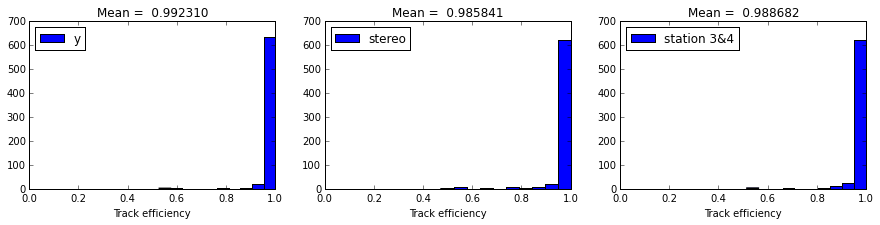

In [34]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

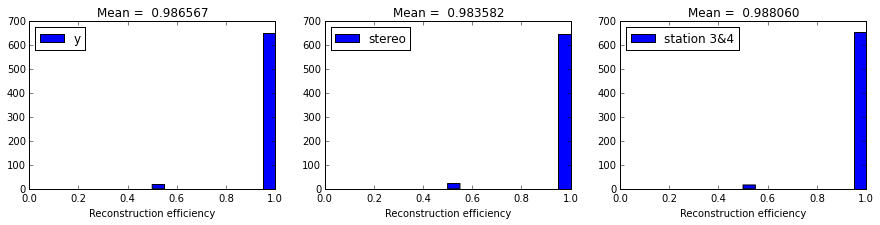

In [35]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [36]:
combinations_quality.mean(axis=0)

EventID      2555.164179
RecoEff         0.953731
GhostRate       0.001493
CloneRate       0.000000
NCombined       1.907463
dtype: float64

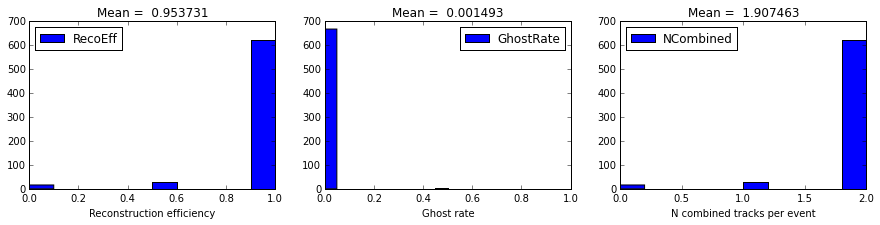

In [37]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

92.9850746269


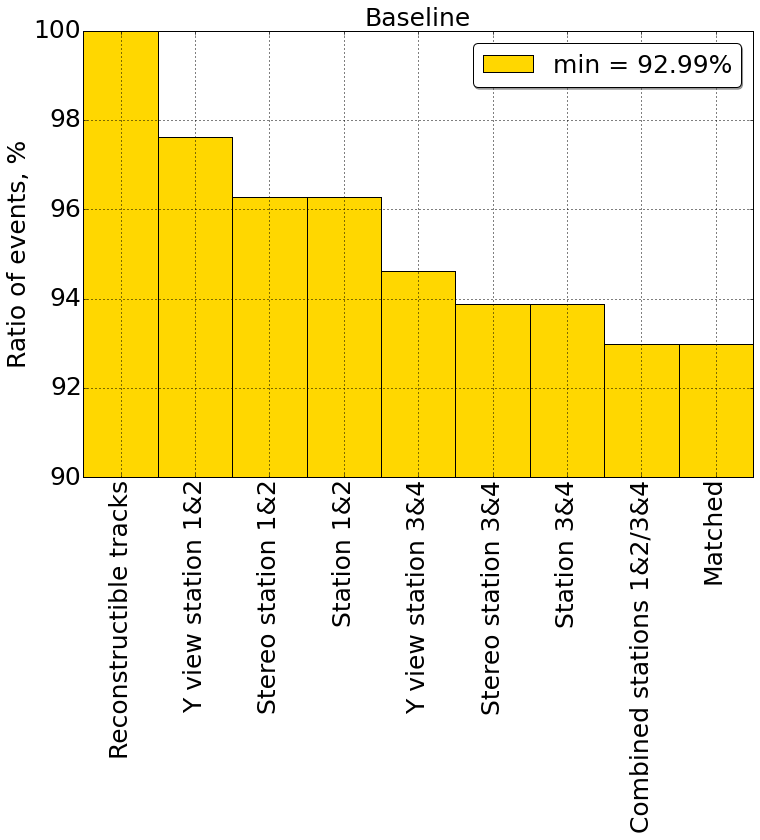

In [38]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages[pass_stages.columns[1:]].sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(12,8))
plt.bar(x, bar_values, width=1., color='gold', align='center', label='min = ' + str(numpy.round(bar_values[-1], 2)) + '%')
plt.xticks(x, bar_labels, rotation=90, fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(-0.5, 8.5)
plt.ylim(90, 100)
#plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=25)
plt.grid(linewidth=1)
plt.title('Baseline', size=25)
plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
plt.show()

# Momentum

In [39]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

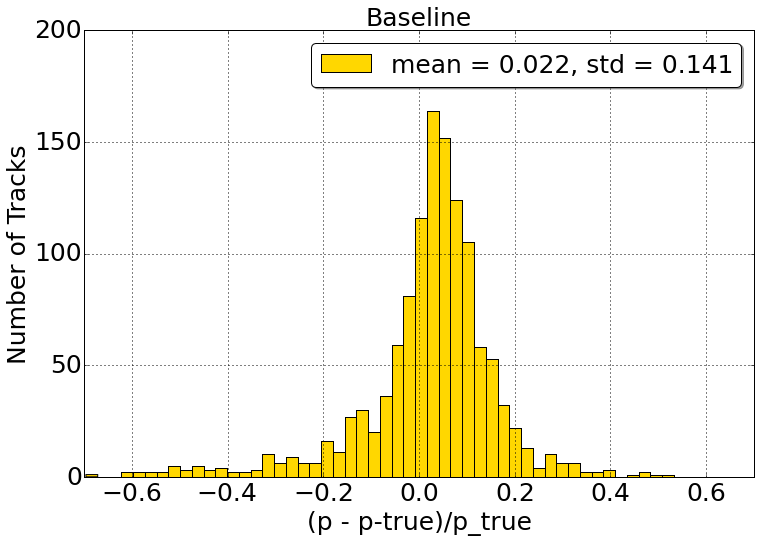

In [40]:
plt.figure(figsize=(12, 8))
q = -p_err[numpy.isfinite(p_err)*(numpy.abs(p_err)<=0.7)]
l = 'mean = ' + str(numpy.round(q.mean(), 3)) + ', std = ' + str(numpy.round(q.std(), 3))
plt.hist(q, bins=50, normed=False, label=l, color='gold')

plt.title('Baseline', size=25)
plt.legend(loc="best", prop={'size':25},  shadow=True, fancybox=True)
plt.xlabel('(p - p-true)/p_true', fontsize=25)
plt.ylabel('Number of Tracks', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0, 200)
plt.xlim(-0.7, 0.7)
plt.grid(linewidth=1)
plt.show()

# Not recognized tracks

In [41]:
selection = (pass_stages.Y12.values == 1)*(pass_stages.Stereo12.values == 0)
pass_stages[selection]

,EventID,RecoEvents,Y12,Stereo12,Stations12,Y34,Stereo34,Stations34,Combination,Matching
38,270,1,1,0,0,0,0,0,0,0
133,1023,1,1,0,0,0,0,0,0,0
197,1528,1,1,0,0,0,0,0,0,0
220,1722,1,1,0,0,0,0,0,0,0
353,2771,1,1,0,0,0,0,0,0,0
453,3406,1,1,0,0,0,0,0,0,0
489,3670,1,1,0,0,0,0,0,0,0
498,3749,1,1,0,0,0,0,0,0,0
502,3781,1,1,0,0,0,0,0,0,0


In [42]:
bad_events = pass_stages[selection]['EventID'].values

270.0


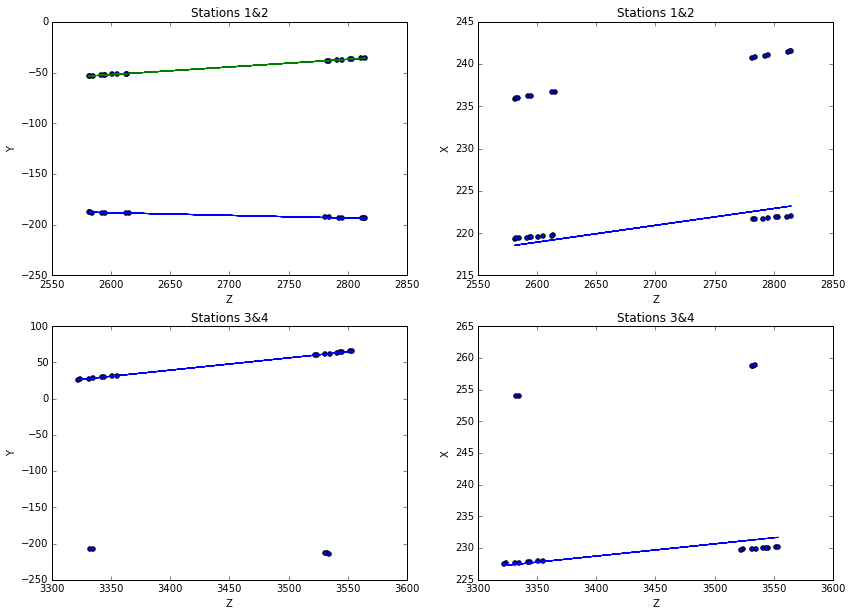

1023.0


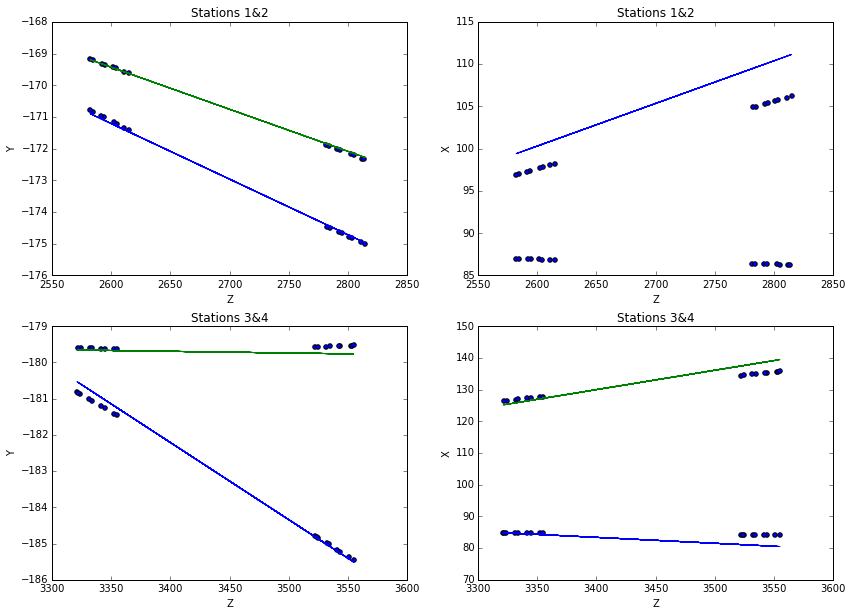

1528.0


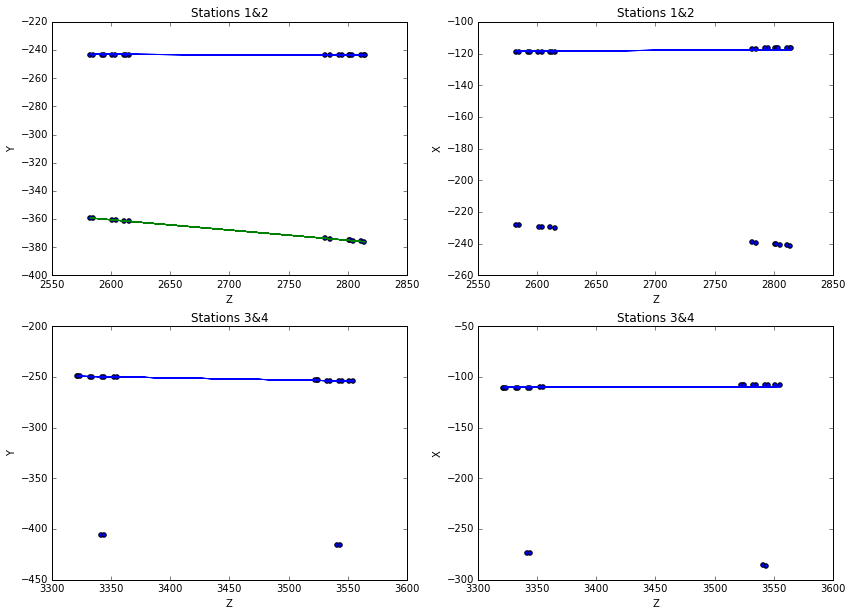

1722.0


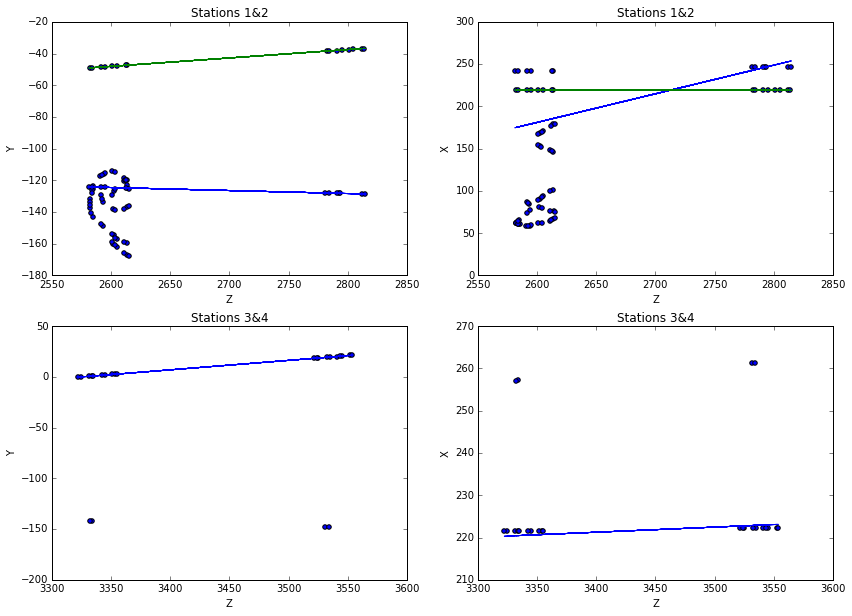

2771.0


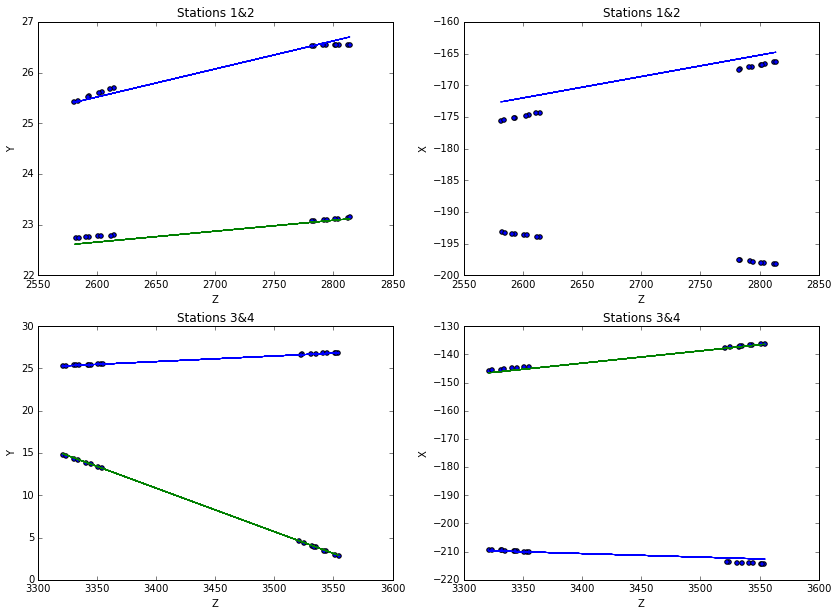

3406.0


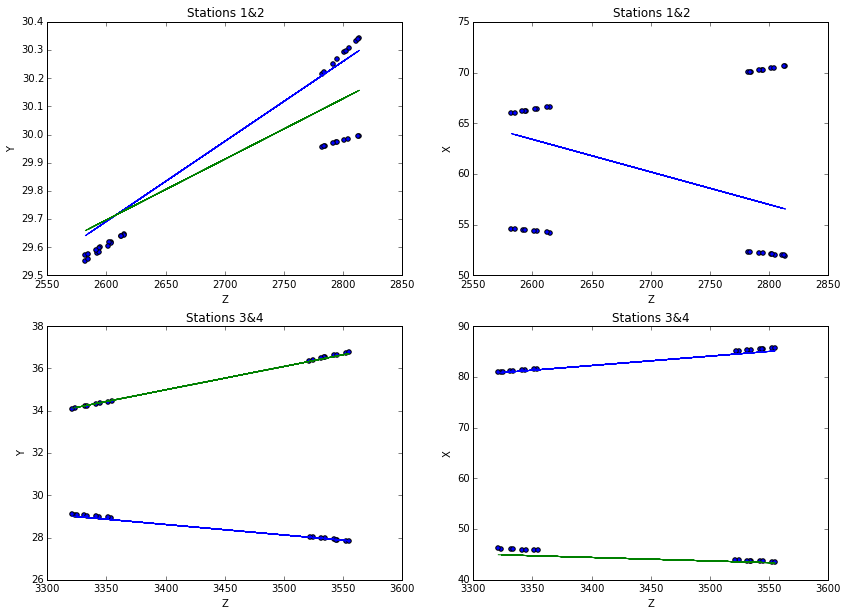

3670.0


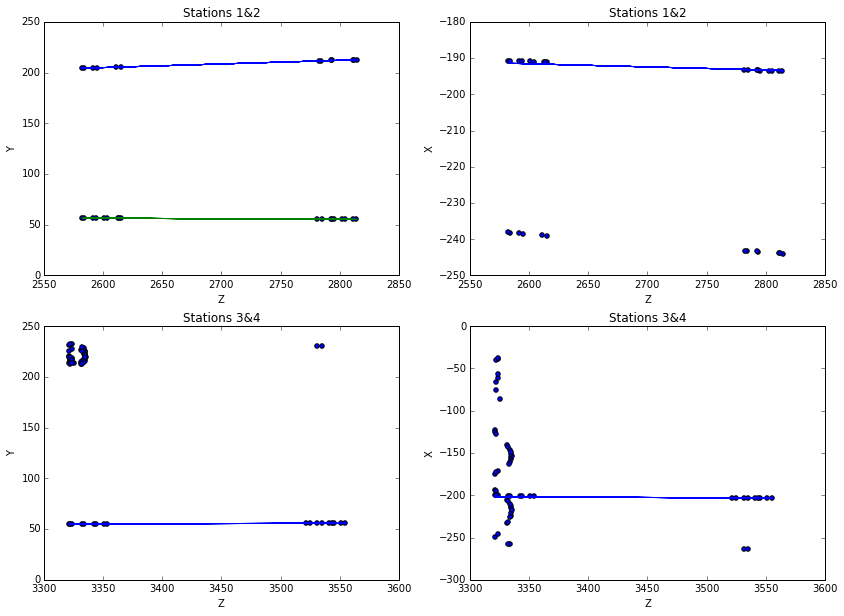

3749.0


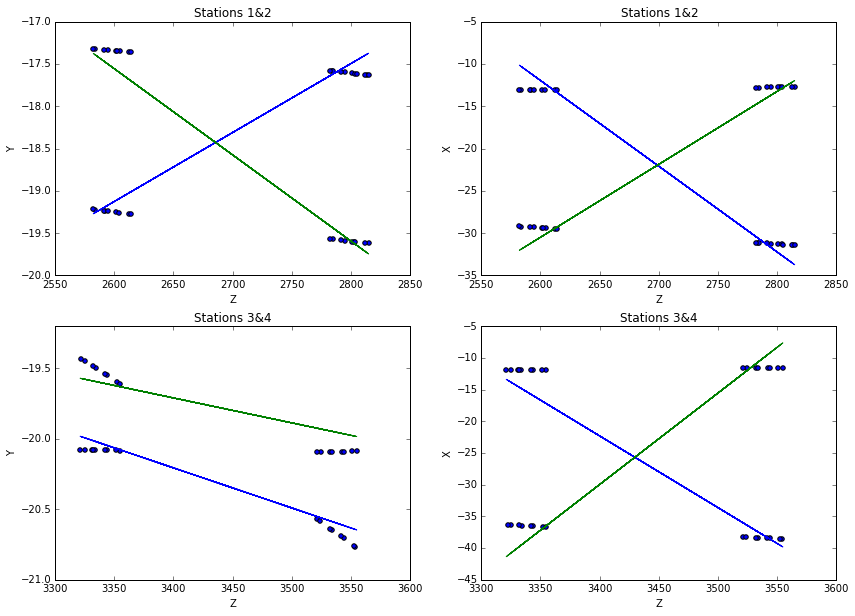

3781.0


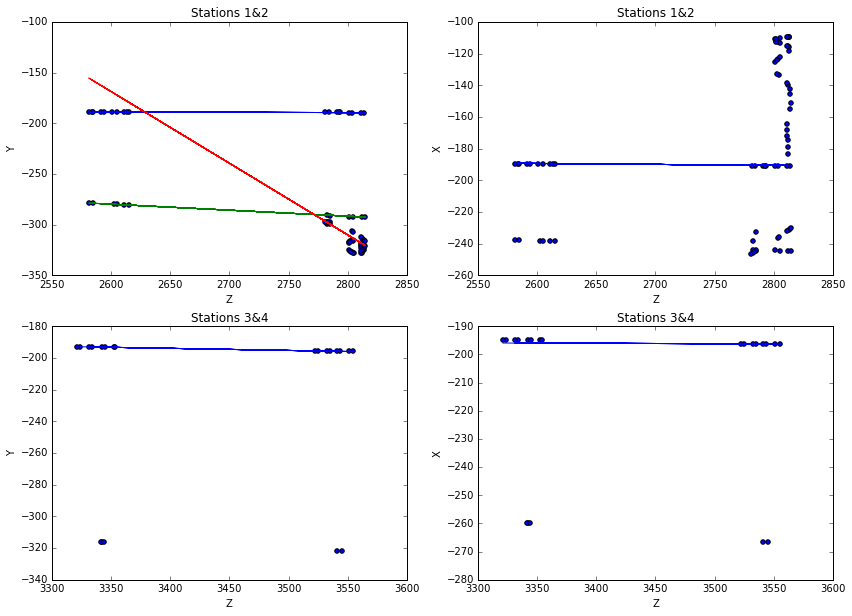

In [43]:
from utils import plot_event

for event_id in bad_events:
    print event_id
    plot_event(event_id, data, tracks)